<a href="https://colab.research.google.com/github/fedorgrab/EAI6000/blob/master/week_4_lab_neural_networks_in_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Week 4 Lab: Neural Networks in practice

In [1]:
from IPython.display import set_matplotlib_formats, display
from contextlib import suppress
with suppress(Exception):
  %tensorflow_version 2.x

from tensorflow import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from cycler import cycler
plt.style.use("seaborn")

  
print("Using Keras", keras.__version__)
%matplotlib inline
plt.rcParams['figure.dpi'] = 125 # Use 300 for PDF, 100 for slides


TensorFlow 2.x selected.
Using Keras 2.2.4-tf


### Overview
* Solving basic classification and regression problems
* Handling textual data
* Model selection (and overfitting)

## Solving basic problems
* Binary classification (of movie reviews)
* Multiclass classification (of news topics)
* Regression (of house prices)

Examples from _Deep Learning with Python_, by _François Chollet_

### Binary classification
* Dataset: 50,000 IMDB reviews, labeled positive (1) or negative (0)
    - Included in Keras, with a 50/50 train-test split
* Each row is one review, with only the 10,000 most frequent words retained
* Each word is replaced by a _word index_ (word ID)

In [2]:
from keras.datasets import imdb

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)
print("Encoded review: ", train_data[0][0:10])

word_index = imdb.get_word_index()
reverse_word_index = dict(map(reversed, word_index.items()))

print("Original review: ", " ".join([
    reverse_word_index.get(i - 3, "?")
    for i in train_data[0]][0:10]
))

Using TensorFlow backend.


Encoded review:  [1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65]
Original review:  ? this film was just brilliant casting location scenery story


#### Preprocessing
* We can't input lists of categorical value to a neural net, we need to create tensors
* One-hot-encoding:
    -  10000 features, '1.0' if the word occurs
* Word embeddings (word2vec):
    - Map each word to a dense vector that represents it (it's _embedding_)
    - _Embedding_ layer: pre-trained layer that looks up the embedding in a dictionary 
    - Converts 2D tensor of word indices (zero-padded) to 3D tensor of embeddings
* Let's do One-Hot-Encoding for now. We'll come back to _Embedding_ layers.
* Also vectorize the labels: from 0/1 to float
    - Binary classification works with one output node

In [0]:
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))

    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.

    return results

x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

#### Understanding the format of IMDB dataset
1. Train_data and test_data are an array of lists. What does the length of this array correspond to? What does the length of each list correspond to?
2. What are the sizes of the vectorized x_train and x_test? What do the dimensions correspond to?
3. What is the most common word in the first review in the training data? Hint: use the word index (see above)? 
4. Print the first review to verify. 

In [4]:
from scipy.stats import mode

first_review = train_data[0]
most_common_word_index = mode(first_review)[0][0]
most_common_word = reverse_word_index[4 - 3]

print(f"The most common word in the first review is '{most_common_word}'")
print(" ".join([reverse_word_index.get(i - 3, "?") for i in train_data[0]]))

The most common word in the first review is 'the'
? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and shoul

1. Lenght of train_data and test_data represents number of IMDB reviews
2. Length of each list (element of train_data and test_data) represents number of words in each review.
3. The most common word in the first 

#### Building the network
* We can solve this problem using a network of _Dense_ layers and the _ReLU_ activation function.
* How many layers? How many hidden units for layer?
    - Start with 2 layers of 16 hidden units each
    - We'll optimize this soon
* Output layer: single unit with _sigmoid_ activation function
    - Close to 1: positive review, close to 0: negative review
* Use binary_crossentropy loss

In [0]:
from tensorflow.keras import models
from tensorflow.keras import layers 

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(
    optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"]
)

#### Model selection
* How many epochs do we need for training?
* Take a validation set of 10,000 samples from the training set
* Train the neural net and track the loss after every iteration on the validation set
    - This is returned as a `History` object by the `fit()` function 
* We start with 20 epochs in minibatches of 512 samples


In [0]:
x_val, partial_x_train = x_train[:10000], x_train[10000:]
y_val, partial_y_train = y_train[:10000], y_train[10000:]

history = model.fit(
    partial_x_train, 
    partial_y_train,
    epochs=20, 
    batch_size=512, 
    verbose=2, # did not understand why it's 2 here. They say in tensorflow documentation that the value should be either 0 or 1
    validation_data=(x_val, y_val)
)

#### Evaluate model performance during training
1. Plot the training and validation loss as a function of training epoch. Describe what happens during the training in terms of under or overfitting.
2. Plot the training and validation accuracy as a function of the training epoch.

Hint: these quantities are contained in the dict history.history.

In [0]:
def plot_fitting_history(values, color, label, epoch_num):
    plt.plot(list(range(1,epoch_num)), values, marker=".", c=color, label=label)    

def plot_fitting_history(values, colors, labels, epoch_num, title):
    for i in range(len(labels)):
        plt.plot(
            list(range(1, epoch_num + 1)),
            values[i],
            marker=".",
            c=colors[i],
            label=labels[i]
        )

    plt.title(title)
    if epoch_num <= 50:
        plt.xticks(list(range(0, epoch_num + 1, 2)))
    else:
        plt.xticks(list(range(0, epoch_num + 1, 20)))
    plt.legend()    

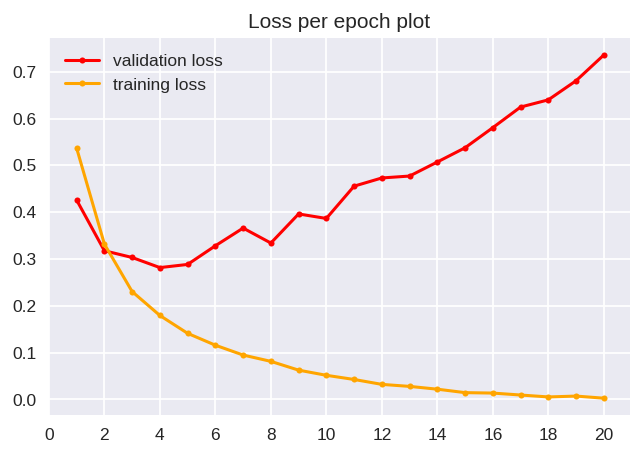

In [8]:
plot_fitting_history(
    [history.history["val_loss"], history.history["loss"]],
    ["red", "orange"],
    ["validation loss", "training loss"],
    20,
    "Loss per epoch plot"
)

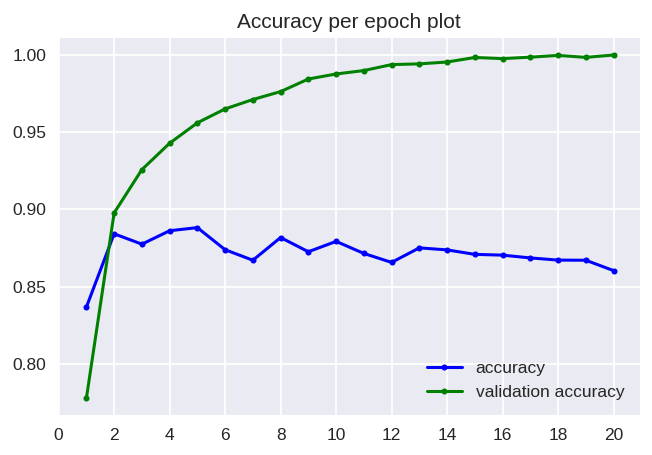

In [9]:
plot_fitting_history(
    [history.history["val_accuracy"], history.history["accuracy"]],
    ["blue", "green"],
    ["accuracy", "validation accuracy"],
    20,
    "Accuracy per epoch plot"
)

As I can see after the 2d epoch model is getting overfitted. However validation accuracy is still raising up. I would say that from 2d to 4th epoch it witnessed considerable growth, so that's why they recommend us to train only before 4th epoch in the next task. Because it would be a little bit overfitted but providing better reuslts. Also I was surfing through reddit topics about AI and one person said "In AI the best fit is always an overfit", It was a little wild for me but in a while I realised that actually all my models I made on the class with our examples were overfitted a little bit. So now I'm thinking that this guy from the reddit was right. I mean I understand there is a trade-off to always think about, but I think I should shift a threshold to overfit a little bit (That's what the book writer actually does). 

But why no one says it directly? All the books we worked so far only said "There are a overfitting and underfitting – both are bad", but no one said "There are overfitting and underfitting – both are bad, but you should overfit a little bit to perform better, oldsport". 

Is it a secret or what?

#### Early stopping
One simple technique to avoid overfitting is to use the validation set to 'tune' the optimal number of epochs
* In this case, we could stop after 4 epochs


In [10]:
model.fit(x_train, y_train, epochs=4, batch_size=512, verbose=2)
result = model.evaluate(x_test, y_test)
print("Loss: {:.4f}, Accuracy:  {:.4f}".format(*result))

Train on 25000 samples
Epoch 1/4
25000/25000 - 2s - loss: 0.2248 - accuracy: 0.9446
Epoch 2/4
25000/25000 - 2s - loss: 0.1354 - accuracy: 0.9597
Epoch 3/4
25000/25000 - 2s - loss: 0.1007 - accuracy: 0.9690
Epoch 4/4
25000/25000 - 2s - loss: 0.0764 - accuracy: 0.9767
25000/25000 [==============================] - 2s 86us/sample - loss: 0.5031 - accuracy: 0.8595
Loss: 0.5031, Accuracy:  0.8595


#### Predictions
1. Print the first review that were correctly classified along with the predicted value.
2. Print the first review that were misclassified along with the predicted value. Can you explain why the model likely failed? How confident was the model?

In [0]:
predicted_classes = model.predict_classes(x_test).reshape(25000)
prediction_probabilities = model.predict(x_test)

In [12]:
correctly_classified_query = test_labels == predicted_classes
missclassified_query = test_labels != predicted_classes

correctly_classified_reviews = test_data[correctly_classified_query]
missclassified_reviews = test_data[missclassified_query]

print(" ".join([reverse_word_index.get(i - 3, "?") for i in correctly_classified_reviews[0]]))
print(" ".join([reverse_word_index.get(i - 3, "?") for i in missclassified_reviews[0]]))

? please give this one a miss br br ? ? and the rest of the cast rendered terrible performances the show is flat flat flat br br i don't know how michael madison could have allowed this one on his plate he almost seemed to know this wasn't going to work out and his performance was quite ? so all you madison fans give this a miss
? i generally love this type of movie however this time i found myself wanting to kick the screen since i can't do that i will just complain about it this was absolutely idiotic the things that happen with the dead kids are very cool but the alive people are absolute idiots i am a grown man pretty big and i can defend myself well however i would not do half the stuff the little girl does in this movie also the mother in this movie is reckless with her children to the point of neglect i wish i wasn't so angry about her and her actions because i would have otherwise enjoyed the flick what a number she was take my advise and fast forward through everything you see

I think that model thought that first missclissified review is a good one, because it seems tricky for model. It has many positive words like "love", "enjoy" and so on.

#### Takeaways
* Neural nets require a lot of preprocessing to create tensors
* Dense layers with ReLU activation can solve a wide range of problems
* Binary classification can be done with a Dense layer with a single unit, sigmoid activation, and binary cross-entropy loss
* Neural nets overfit easily
* Many design choices have an effect on accuracy and overfitting. One can try:
    - 1 or 3 hidden layers
    - more or fewer hidden units (e.g. 64)
    - MSE loss instead of binary cross-entropy
    - `tanh` activation instead of `ReLU`

### Regularization: build smaller networks
* The easiest way to avoid overfitting is to use a simpler model
* The number of learnable parameters is called the model _capacity_
* A model with more parameters has a higher _memorization capacity_
    - The entire training set can be `stored` in the weights
    - Learns the mapping from training examples to outputs
* Forcing the model to be small forces it to learn a compressed representation that generalizes better
    - Always a trade-off between too much and too little capacity
* Start with few layers and parameters, incease until you see diminisching returns

Let's try this on our movie review data, with 4 units per layer


In [0]:
from keras.datasets import imdb
import numpy as np

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1. 
        
    return results


x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

In [0]:
from tensorflow.keras import models
from tensorflow.keras import layers 
import matplotlib.pyplot as plt

original_model = models.Sequential()
original_model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
original_model.add(layers.Dense(16, activation='relu'))
original_model.add(layers.Dense(1, activation='sigmoid'))

original_model.compile(
    optimizer='rmsprop',
    loss='binary_crossentropy',
    metrics=['acc']
)

smaller_model = models.Sequential()
smaller_model.add(layers.Dense(4, activation='relu', input_shape=(10000,)))
smaller_model.add(layers.Dense(4, activation='relu'))
smaller_model.add(layers.Dense(1, activation='sigmoid'))

smaller_model.compile(
    optimizer='rmsprop',
    loss='binary_crossentropy',
    metrics=['acc']
)

original_hist = original_model.fit(
    x_train, y_train,
    epochs=20,
    batch_size=512,
    verbose=2,
    validation_data=(x_test, y_test)
)

smaller_model_hist = smaller_model.fit(
    x_train, y_train,
    epochs=20,
    batch_size=512, 
    verbose=2,
    validation_data=(x_test, y_test)
)

1. Plot the validation loss for the original and smaller models. How does the smaller model behave compared to the original?

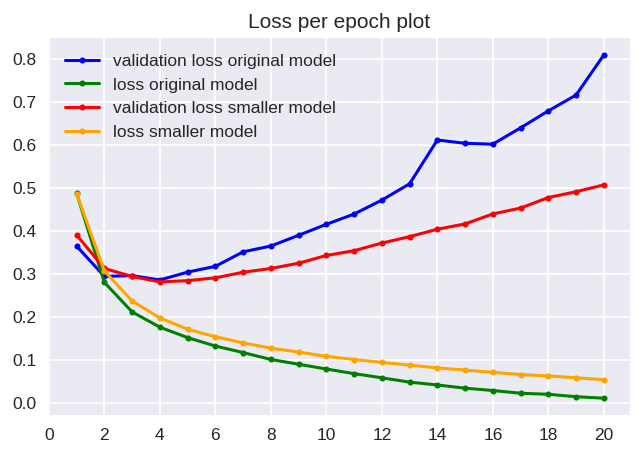

In [15]:
plot_fitting_history(
    [original_hist.history["val_loss"], original_hist.history["loss"], smaller_model_hist.history["val_loss"], smaller_model_hist.history["loss"]],
    ["blue", "green", "red", "orange"],
    ["validation loss original model", "loss original model", "validation loss smaller model", "loss smaller model"],
    20,
    "Loss per epoch plot"
)

I think smaller model performed a little better, cause validation loss of smaller model is less.

### Regularization: Weight regularization
* As we did many times before, we can also add weight regularization to our loss function
- L1 regularization: leads to _sparse networks_ with many weights that are 0
- L2 regularization: leads to many very small weights
    - Also called _weight decay_ in neural net literature
* In Keras, add `kernel_regularizer` to every layer

In [0]:
from tensorflow.keras import regularizers
from tensorflow.keras import models
from tensorflow.keras import layers 
import matplotlib.pyplot as plt

l2_model = models.Sequential()
l2_model.add(layers.Dense(
    units=16,
    kernel_regularizer=regularizers.l2(0.001),
    activation="relu",
    input_shape=(10000,)
))
l2_model.add(layers.Dense(
    units=16,
    kernel_regularizer=regularizers.l2(0.001),
    activation="relu"
))
l2_model.add(layers.Dense(units=1, activation="sigmoid"))

In [0]:
l2_model.compile(
    optimizer="rmsprop",
    loss="binary_crossentropy",
    metrics=["acc"]
)

In [0]:
l2_model_hist = l2_model.fit(
    x_train, y_train,
    epochs=20,
    batch_size=512, verbose=2,
    validation_data=(x_test, y_test)
)

1. Plot the validation loss for the original and l2 regularized models. How does the regularized model behave compared to the original?

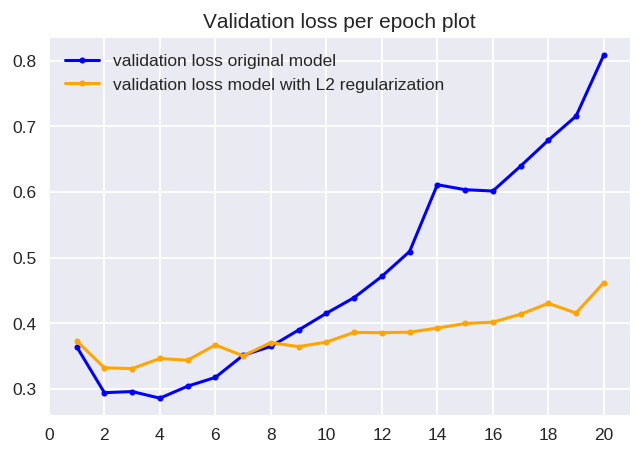

In [19]:
plot_fitting_history(
    [original_hist.history["val_loss"], l2_model_hist.history["val_loss"]],
    ["blue", "orange"],
    ["validation loss original model", "validation loss model with L2 regularization"],
    20,
    "Validation loss per epoch plot"
)

After 6th epoch regularized model performed with a less loss comparing to a non-regularized model

### Regularization: dropout
* One of the most effective and commonly used regularization techniques
* Randomly set a number of outputs of the layer to 0
* Idea: break up accidental non-significant learned patterns 
* _Dropout rate_: fraction of the outputs that are zeroed-out
    - Usually between 0.2 and 0.5
* At test time, nothing is dropped out, but the output values are scaled down by the dropout rate
    - Balances out that more units are active than during training
* In Keras: add `Dropout` layers between the normal layers

In [0]:
from tensorflow.keras import models
from tensorflow.keras import layers 
import matplotlib.pyplot as plt

dpt_model = models.Sequential()
dpt_model.add(layers.Dense(units=16, activation="relu", input_shape=(10000,)))
dpt_model.add(layers.Dropout(rate=0.5))
dpt_model.add(layers.Dense(units=16, activation="relu"))
dpt_model.add(layers.Dropout(rate=0.5))
dpt_model.add(layers.Dense(units=1, activation="sigmoid"))

dpt_model.compile(
    optimizer="rmsprop",
    loss="binary_crossentropy",
    metrics=["acc"]
)

In [0]:
dpt_model_hist = dpt_model.fit(
    x_train, y_train,
    epochs=20,
    batch_size=512, verbose=2,
    validation_data=(x_test, y_test)
)                               

1. Plot the validation loss for the original and dropout models. How does the dropout model behave compared to the original?

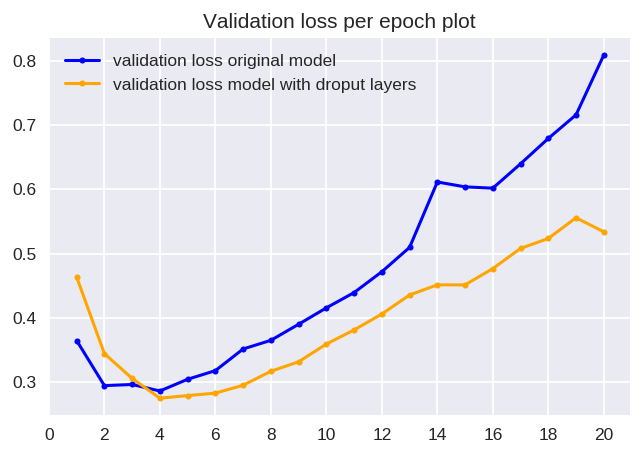

In [22]:
plot_fitting_history(
    [original_hist.history["val_loss"], dpt_model_hist.history["val_loss"]],
    ["blue", "orange"],
    ["validation loss original model", "validation loss model with droput layers"],
    20,
    "Validation loss per epoch plot"
)

After 4th epoch dropout regulirized model showed less loss than non-regularized model. However, from 1 to 4 epochs it showed significantly greater loss.

### Regularization recap
* Get more training data
* Reduce the capacity of the network
* Add weight regularization
* Add dropout
* Either start with a simple model and add capacity
* Or, start with a complex model and then regularize by adding weight regularization and dropout

### Regression
* Dataset: 506 examples of houses and sale prices (Boston)
    - Included in Keras, with a 1/5 train-test split
* Each row is one house price, described by numeric properties of the house and neighborhood
* Small dataset, non-normalized features

In [0]:
from keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) =  boston_housing.load_data()

#### Preprocessing
* Neural nets work a lot better if we normalize the features first. 
* Keras has no built-in support so we have to do this manually (or with scikit-learn)
    - Again, be careful not to look at the test data during normalization
    


In [24]:
import pandas as pd

pd.DataFrame(train_data)

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,1.23247,0.0,8.14,0.0,0.5380,6.142,91.7,3.9769,4.0,307.0,21.0,396.90,18.72
1,0.02177,82.5,2.03,0.0,0.4150,7.610,15.7,6.2700,2.0,348.0,14.7,395.38,3.11
2,4.89822,0.0,18.10,0.0,0.6310,4.970,100.0,1.3325,24.0,666.0,20.2,375.52,3.26
3,0.03961,0.0,5.19,0.0,0.5150,6.037,34.5,5.9853,5.0,224.0,20.2,396.90,8.01
4,3.69311,0.0,18.10,0.0,0.7130,6.376,88.4,2.5671,24.0,666.0,20.2,391.43,14.65
...,...,...,...,...,...,...,...,...,...,...,...,...,...
399,0.21977,0.0,6.91,0.0,0.4480,5.602,62.0,6.0877,3.0,233.0,17.9,396.90,16.20
400,0.16211,20.0,6.96,0.0,0.4640,6.240,16.3,4.4290,3.0,223.0,18.6,396.90,6.59
401,0.03466,35.0,6.06,0.0,0.4379,6.031,23.3,6.6407,1.0,304.0,16.9,362.25,7.83
402,2.14918,0.0,19.58,0.0,0.8710,5.709,98.5,1.6232,5.0,403.0,14.7,261.95,15.79


In [25]:
mean, std = train_data.mean(axis=0), train_data.std(axis=0)
train_data -= mean
train_data /= std

test_data -= mean
test_data /= std

pd.DataFrame(train_data)

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,-0.272246,-0.483615,-0.435762,-0.256833,-0.165227,-0.176443,0.813062,0.116698,-0.626249,-0.595170,1.148500,0.448077,0.825220
1,-0.403427,2.991784,-1.333912,-0.256833,-1.215182,1.894346,-1.910361,1.247585,-0.856463,-0.348433,-1.718189,0.431906,-1.329202
2,0.124940,-0.483615,1.028326,-0.256833,0.628642,-1.829688,1.110488,-1.187439,1.675886,1.565287,0.784476,0.220617,-1.308500
3,-0.401494,-0.483615,-0.869402,-0.256833,-0.361560,-0.324558,-1.236672,1.107180,-0.511142,-1.094663,0.784476,0.448077,-0.652926
4,-0.005634,-0.483615,1.028326,-0.256833,1.328612,0.153642,0.694808,-0.578572,1.675886,1.565287,0.784476,0.389882,0.263497
...,...,...,...,...,...,...,...,...,...,...,...,...,...
399,-0.381973,-0.483615,-0.616568,-0.256833,-0.933487,-0.938177,-0.251223,1.157680,-0.741356,-1.040501,-0.262093,0.448077,0.477421
400,-0.388221,0.358906,-0.609218,-0.256833,-0.796907,-0.038202,-1.888860,0.339660,-0.741356,-1.100681,0.056428,0.448077,-0.848908
401,-0.402030,0.990797,-0.741515,-0.256833,-1.019702,-0.333021,-1.638018,1.430403,-0.971569,-0.613224,-0.717123,0.079439,-0.677769
402,-0.172920,-0.483615,1.245881,-0.256833,2.677335,-0.787241,1.056737,-1.044075,-0.511142,-0.017443,-1.718189,-0.987644,0.420835


#### Building the network
* This is a small dataset, so easy to overfit
    * We use 2 hidden layers of 64 units each
* Use smaller batches, more epochs
* Since we want scalar output, the output layer is one unit without activation
* Loss function is Mean Squared Error (bigger penalty)
* Evaluation metric is Mean Absolute Error (more interpretable)
* We will also use cross-validation, so we wrap the model building in a function, so that we can call it multiple times

1. Create a function build_model that returns the neural network model described above

In [0]:
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(
        units=64,
        activation="relu",
        input_shape=(train_data.shape[1],))
    )
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

#### Cross-validation
* Keras does not have support for cross-validation
* We can implement cross-validation ourselves (seeprovided code below)
* Alternatively, we can wrap a Keras model as a scikit-learn estimator
* Generally speaking, cross-validation is tricky with neural nets
    * Some fold may not converge, or fluctuate on random initialization
    

In [27]:
# implementation of cross-validation
import numpy as np

k = 4
num_val_samples = len(train_data) // k
num_epochs = 20
all_scores = []
for i in range(k):
    print('processing fold #', i)
    # Prepare the validation data: data from partition # k
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    # Prepare the training data: data from all other partitions
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    # Build the Keras model (already compiled)
    model = build_model()
    # Train the model (in silent mode, verbose=0)
    model.fit(partial_train_data, partial_train_targets,
              epochs=num_epochs, batch_size=1, verbose=0)
    # Evaluate the model on the validation data
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=2)
    all_scores.append(val_mae)

processing fold # 0
101/101 - 0s - loss: 10.3869 - mae: 2.0948
processing fold # 1
101/101 - 0s - loss: 10.5403 - mae: 2.4749
processing fold # 2
101/101 - 0s - loss: 14.7961 - mae: 2.5585
processing fold # 3
101/101 - 0s - loss: 16.2830 - mae: 2.9875


1. Train for longer (200 epochs) and keep track of loss after every epoch. Plot and describe the loss as a function of epoch number.

In [0]:
from tensorflow.keras import backend as K
K.clear_session() # Memory clean-up

num_epochs = 200
all_mae_histories = []
for i in range(k):
    print('processing fold #', i)
    # Prepare the validation data: data from partition # k
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    # Prepare the training data: data from all other partitions
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    # Build the Keras model (already compiled)
    model = build_model()
    # Train the model (in silent mode, verbose=0)
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=2)
    mae_history = history.history['val_loss']
    all_mae_histories.append(mae_history)

In [0]:
all_mae_histories = np.array(all_mae_histories)
all_mae_histories_fold_1 = all_mae_histories[0]
all_mae_histories_fold_2 = all_mae_histories[1]
all_mae_histories_fold_3 = all_mae_histories[2]
all_mae_histories_fold_4 = all_mae_histories[3]

mean_mae_histories = ( 
    all_mae_histories_fold_1
    + all_mae_histories_fold_2
    + all_mae_histories_fold_3
    + all_mae_histories_fold_4
) / 4


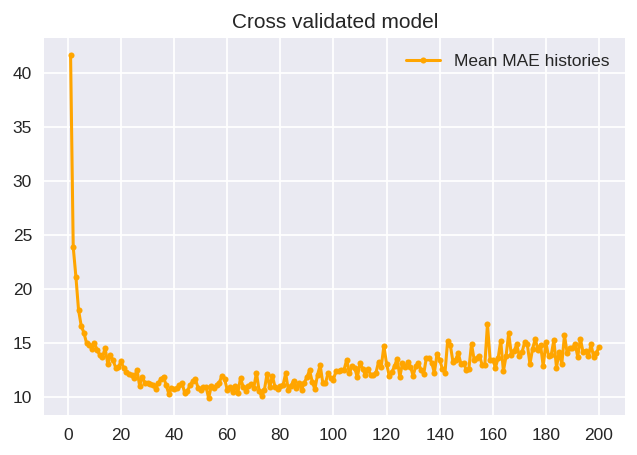

In [30]:
plot_fitting_history([mean_mae_histories], ["orange"], ["Mean MAE histories"], 200, "Cross validated model")

#### Takeaways
* Regression is usually done using MSE loss and MAE for evaluation
* Input data should always be scaled (independent from the test set)
* Small datasets:
    - Use cross-validation
    - Use simple (non-deep) networks
    - Smaller batches, more epochs